# Notebook to try to estimate the "offer success" for a customer. That is, the probability that a customer views and completes an offer in its active time, in that order.

In [75]:
import pandas as pd
import numpy as np
import math
import json
import os
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme='solarizedd')
plt.rcParams['figure.figsize'] = (20.0, 10.0)

import data_utils_mt.utils as utils
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import datetime as dt
from xgboost import XGBClassifier

ROOT = '../..'
DATA = os.path.join(ROOT, 'data')
DATA_RAW = os.path.join(DATA, 'raw')
SRC = os.path.join(ROOT, 'src')

import sys
sys.path.append(SRC)

import src.data.preprocessing as pp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data = pd.read_pickle(os.path.join(DATA, 'interim', 'static_data.pkl'))
data = pp.anonimize_data(data)

In [3]:
data.head()

,time,age,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,...,expected_finish,finish,success,view_time,viewed,actual_reward,profit_in_duration,profit_until_complete,spent_in_duration,spent_until_complete
0,168,33.0,1.0,72000.0,0,17277,0.0,3.0,informational,0.0,...,240.0,240.0,0,192.0,1,0.0,22.16,22.16,22.16,22.16
1,336,33.0,1.0,72000.0,0,17277,0.0,4.0,informational,0.0,...,432.0,432.0,0,372.0,1,0.0,8.57,8.57,8.57,8.57
2,408,33.0,1.0,72000.0,0,17277,5.0,5.0,bogo,5.0,...,528.0,414.0,0,NaN,0,5.0,17.68,3.57,22.68,8.57
3,504,33.0,1.0,72000.0,0,17277,10.0,10.0,discount,2.0,...,744.0,528.0,0,NaN,0,2.0,94.87,12.11,96.87,14.11
4,576,33.0,1.0,72000.0,0,17277,10.0,7.0,discount,2.0,...,744.0,576.0,0,NaN,0,2.0,67.20,8.27,69.20,10.27


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76277 entries, 0 to 76276
Data columns (total 25 columns):
time                     76277 non-null int64
age                      66501 non-null float64
gender                   66501 non-null float64
income                   66501 non-null float64
missing_demographics     76277 non-null int64
member_epoch_days        76277 non-null int64
difficulty               76277 non-null float64
duration                 76277 non-null float64
offer_type               76277 non-null object
reward_t                 76277 non-null float64
channel_web              76277 non-null float64
channel_social           76277 non-null float64
channel_mobile           76277 non-null float64
channel_email            76277 non-null float64
completed                76277 non-null int64
expected_finish          76277 non-null float64
finish                   76277 non-null float64
success                  76277 non-null int64
view_time                57227 non-nul

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder

In [17]:
class BasicEncoder(BaseEstimator, TransformerMixin):
    """ Transforms the Basic dataset. """
    
    def __init__(self):
        super(BaseEstimator, self).__init__()
        self.offer_type_encoder = LabelEncoder()
        
    def fit(self, X, y=None):
        self.offer_type_encoder.fit(X['offer_type'])
        return self
        
    def transform(self, X):
        res = X.copy()
        res['offer_type'] = self.offer_type_encoder.transform(X['offer_type'])
        return res

In [18]:
encoder = BasicEncoder()
X = encoder.fit_transform(data)
X.head()

,time,age,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,...,expected_finish,finish,success,view_time,viewed,actual_reward,profit_in_duration,profit_until_complete,spent_in_duration,spent_until_complete
0,168,33.0,1.0,72000.0,0,17277,0.0,3.0,2,0.0,...,240.0,240.0,1,192.0,1,0.0,22.16,22.16,22.16,22.16
1,336,33.0,1.0,72000.0,0,17277,0.0,4.0,2,0.0,...,432.0,432.0,1,372.0,1,0.0,8.57,8.57,8.57,8.57
2,408,33.0,1.0,72000.0,0,17277,5.0,5.0,0,5.0,...,528.0,414.0,0,NaN,0,5.0,17.68,3.57,22.68,8.57
3,504,33.0,1.0,72000.0,0,17277,10.0,10.0,1,2.0,...,744.0,528.0,0,NaN,0,2.0,94.87,12.11,96.87,14.11
4,576,33.0,1.0,72000.0,0,17277,10.0,7.0,1,2.0,...,744.0,576.0,0,NaN,0,2.0,67.20,8.27,69.20,10.27


In [8]:
data.loc[data.offer_type == 'informational', 'success'] = data.loc[
    data.offer_type == 'informational', 'viewed']

In [9]:
data.head()

,time,age,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,...,expected_finish,finish,success,view_time,viewed,actual_reward,profit_in_duration,profit_until_complete,spent_in_duration,spent_until_complete
0,168,33.0,1.0,72000.0,0,17277,0.0,3.0,informational,0.0,...,240.0,240.0,1,192.0,1,0.0,22.16,22.16,22.16,22.16
1,336,33.0,1.0,72000.0,0,17277,0.0,4.0,informational,0.0,...,432.0,432.0,1,372.0,1,0.0,8.57,8.57,8.57,8.57
2,408,33.0,1.0,72000.0,0,17277,5.0,5.0,bogo,5.0,...,528.0,414.0,0,NaN,0,5.0,17.68,3.57,22.68,8.57
3,504,33.0,1.0,72000.0,0,17277,10.0,10.0,discount,2.0,...,744.0,528.0,0,NaN,0,2.0,94.87,12.11,96.87,14.11
4,576,33.0,1.0,72000.0,0,17277,10.0,7.0,discount,2.0,...,744.0,576.0,0,NaN,0,2.0,67.20,8.27,69.20,10.27


In [85]:
def get_success_data(
    basic_dataset_path=os.path.join(DATA, 
                                    'interim',
                                    'static_data.pkl'),
    time_limit = 450,
    informational_success=True
):
    """ 
    Generates the dataset to predict whether an offer was successful.
    An offer is considered successful if it is viewed and then completed. In
    the case of informational offers a visualization alone may be considered a
    success or not.
    Args:
        basic_dataset_path(str): The path to the pickle containing the basic
            dataset
        time_limit(int): The limit to split the train and test sets.
        informational_success(boolean): Whether a visualization of an 
            informational offer should be considered as a success.
    
    Returns:
        X_train(pd.DataFrame): The training dataset.
        X_test(pd.DataFrame): The test dataset.
        y_train(pd.Series): The training target.
        y_test(pd.Series): The test target.
        BasicEncoder: An encoder to use in a ML pipeline.
    """
    
    data = pd.read_pickle(basic_dataset_path)
    data = pp.anonimize_data(data)
    if informational_success:
        data.loc[data.offer_type == 'informational', 'success'] = data.loc[
            data.offer_type == 'informational', 'viewed']
    
    X_train = data[data.time < time_limit].drop(pp.FUTURE_INFO, axis=1)
    y_train = data.loc[data.time < time_limit, 'success']
    X_test = data[data.time >= time_limit].drop(pp.FUTURE_INFO, axis=1)
    y_test = data.loc[data.time >= time_limit, 'success']
    
    # Drop the columns that depend on absolute time
    X_train = X_train.drop(['time', 'expected_finish'], axis=1)
    X_test = X_test.drop(['time', 'expected_finish'], axis=1)
    
    encoder = pp.BasicEncoder()
    
    return X_train, X_test, y_train, y_test, encoder

In [86]:
X_train, X_test, y_train, y_test, encoder = get_success_data()

In [87]:
from sklearn.pipeline import Pipeline

In [88]:
model = Pipeline([
    ('encoder', encoder),
    ('estimator', XGBClassifier(max_depth=7, n_estimators=1000, n_jobs=-1))
])

In [89]:
from time import time
from sklearn.metrics import confusion_matrix, classification_report, f1_score

In [90]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    """ 
    Shows some training and test results. Returns the trained model and the 
    predictions.
    """
    # Fit the model
    tic = time()
    model.fit(X_train, y_train)
    toc = time()
    print('Training time: {} seconds.'.format(toc - tic))
    
    # Predict and show results
    y_train_pred = model.predict(X_train)
    print('-'*44 + 'TRAIN RESULTS' + '-'*44)
    print('Confusion Matrix:')
    print(confusion_matrix(y_train, y_train_pred))
    print('Classification Report:')
    print(classification_report(y_train, y_train_pred))
    print('-'*100)
    
    y_test_pred = model.predict(X_test)
    print('-'*44 + 'TEST RESULTS' + '-'*44)
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_test_pred))
    print('Classification Report:')
    print(classification_report(y_test, y_test_pred))
    print('-'*100)
    
    print('\n' + '_'*51)
    print('| MAIN METRIC (test f1-score): {} |'.format(
        f1_score(y_test, y_test_pred)))
    print('-'*51)
    
    return model, y_train_pred, y_test_pred

In [91]:
model, y_train_pred, y_test_pred = evaluate_model(model, X_train, X_test, y_train, y_test)

Training time: 104.2918050289154 seconds.
--------------------------------------------TRAIN RESULTS--------------------------------------------
Confusion Matrix:
[[23433  3442]
 [ 3490 20443]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87     26875
           1       0.86      0.85      0.86     23933

   micro avg       0.86      0.86      0.86     50808
   macro avg       0.86      0.86      0.86     50808
weighted avg       0.86      0.86      0.86     50808

----------------------------------------------------------------------------------------------------
--------------------------------------------TEST RESULTS--------------------------------------------
Confusion Matrix:
[[10080  3908]
 [ 3432  8049]]
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.72      0.73     13988
           1       0.67      0.70      0.69     11481

   micro avg       

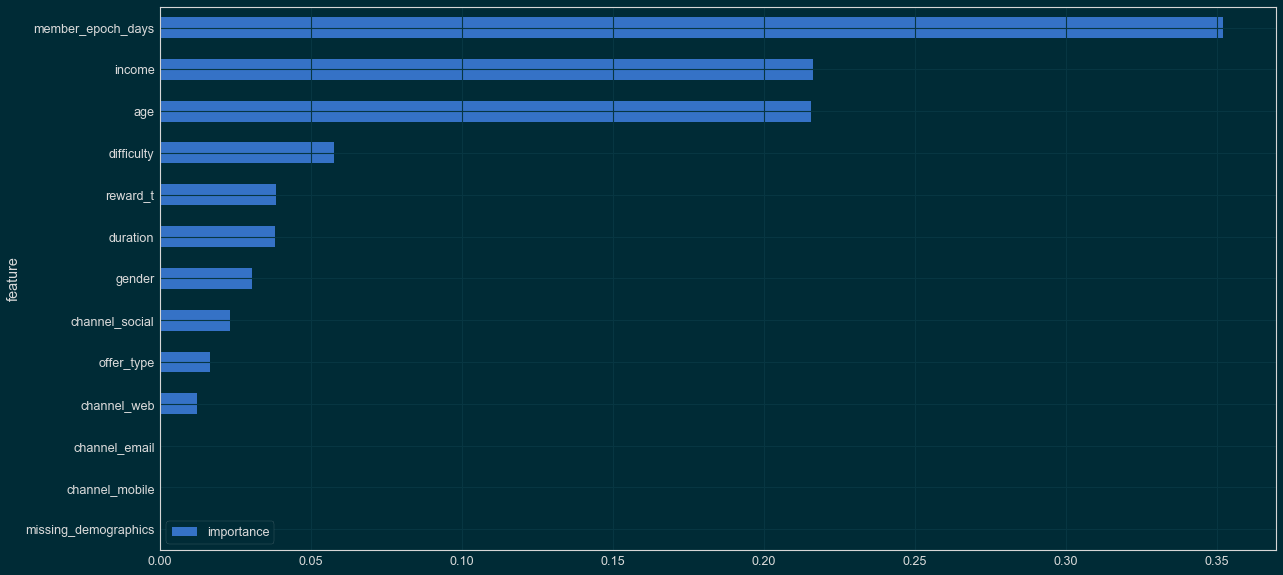

In [92]:
feat_imp = np.vstack([X_train.columns, 
                      model.named_steps['estimator'].feature_importances_]).T
feat_imp = pd.DataFrame(feat_imp, columns=['feature', 'importance'])
feat_imp = feat_imp.sort_values(by='importance').set_index('feature')
feat_imp.plot(kind='barh')

In [42]:
X_train.time.value_counts().sort_index()

0      12650
168    12669
336    12711
408    12778
Name: time, dtype: int64

In [44]:
X_test.time.value_counts().sort_index()

504    12704
576    12765
Name: time, dtype: int64